In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Detección del tablero de ajedrez

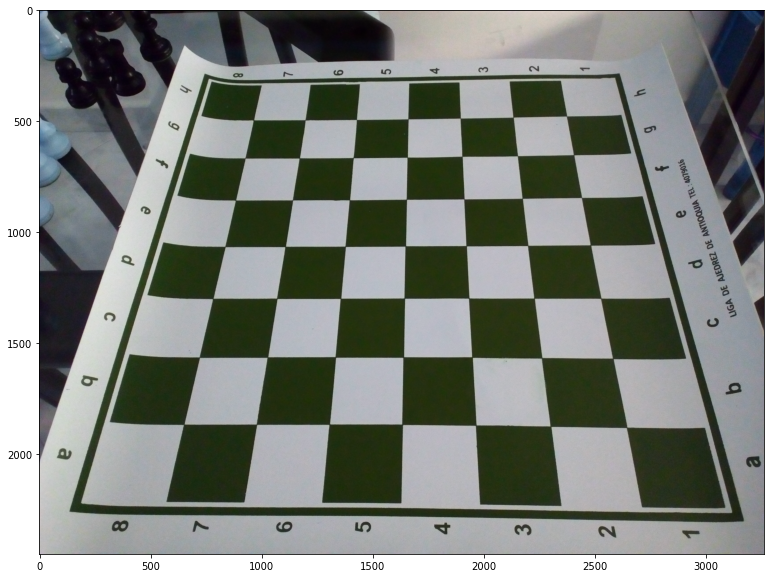

In [2]:
board = cv2.imread('./photos2/board2.jpg')
plt.figure(figsize = (16,10))
plt.imshow(board)

In [3]:
#Encuentra los bordes de una cuadricula, para un tablero de ajedrez (8x8)
found, corners = cv2.findChessboardCorners(board, (7, 7))
found

True

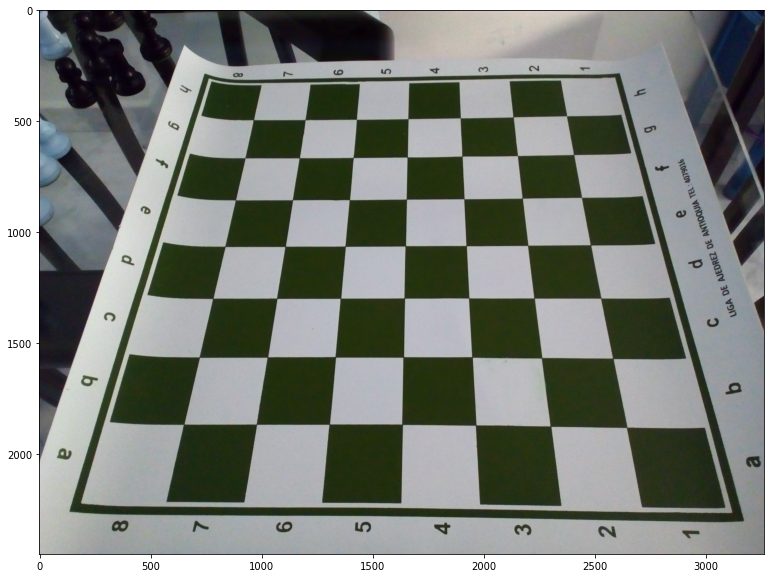

In [4]:
# Copy chessboard
chessboard = cv2.imread('./photos2/board3.jpg')
plt.figure(figsize = (16,10))
plt.imshow(chessboard)

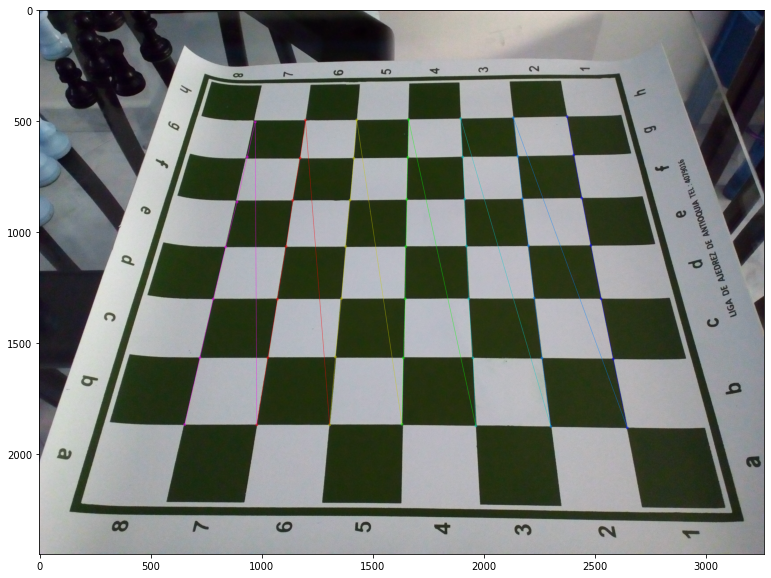

In [5]:
# Dibuja las intercepciones del tablero.
# Se destaca que no encuentra las casillas más externas por lo que estas se deben construir en base a la distanca entre dos casillas consecutivas
board2= board.copy()
cv2.drawChessboardCorners(board2, (7, 7), corners, found)

# Tablero ocn las intercepciones marcadas
plt.figure(figsize = (16,10))
plt.imshow(board2)

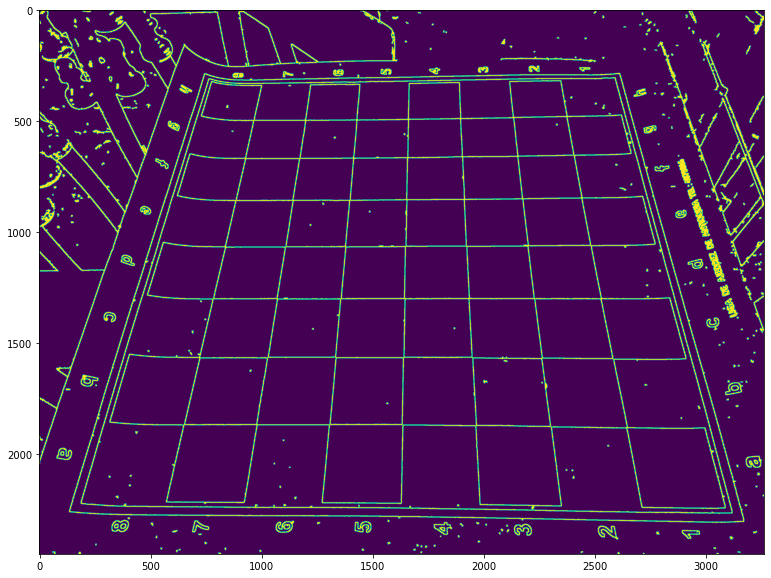

In [6]:
kernel = np.ones((3, 3), np.uint8) # Elemento estructurante para dilatar la imágen.

img = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY) # Conversión de RGB a escala de grises de la imágen del tablero


img = cv2.GaussianBlur(img, (3,3), 1) # Suaviza la imágen
img = cv2.Canny(img, 25, 60) # Detectan los bordes en la imágen

img = cv2.dilate(img, kernel, iterations=2) # Tratamiento morfológico

# Tablero donde se observan los bordes detectados por el método Canny.
plt.figure(figsize = (16,10))
plt.imshow(img)

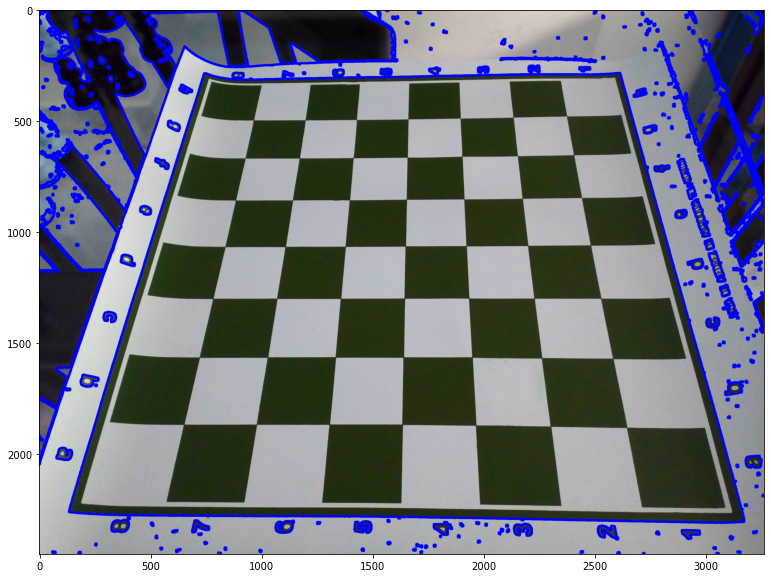

In [7]:
contours, h = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # Se detectan todos los contornos que hay en la imagen en base a los bordes econtrados
cv2.drawContours(board, contours, -1, (0, 0, 255), 10) # Dibujas los contornos

# Contornos detectados a partir de los bordes
plt.figure(figsize = (16,10))
plt.imshow(board)

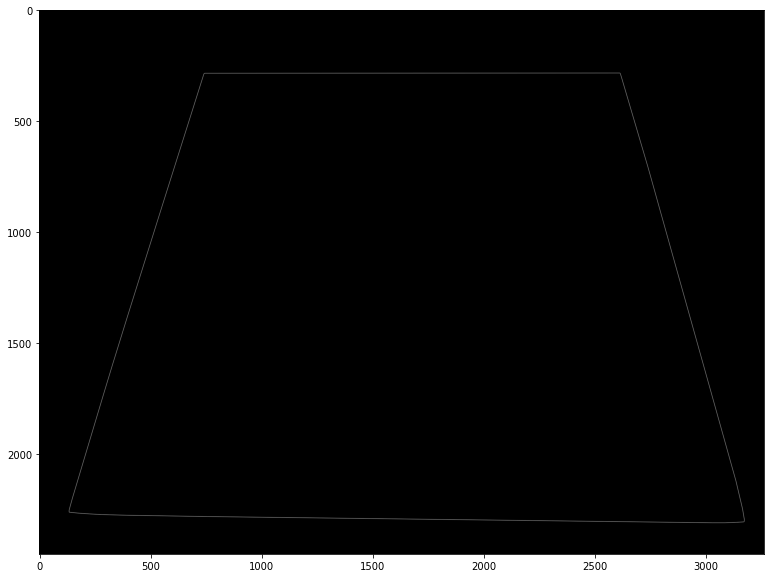

In [8]:
hull = []
cntmax = max(contours, key= lambda x: cv2.contourArea(x)) # Determina el contorno con mayor área, en este caso el tablero

drawing = np.zeros((img.shape[0], img.shape[1], 3), np.uint8) # Crea una imágen de fondo negro
color = (255, 255, 255) # white - color for convex hull

hull.append(cv2.convexHull(cntmax, False)) # Determina si el contorno es un polígono convexo
cv2.drawContours(drawing, hull, -1, color, 1, 16) # Dibuja el polígono

# Imagén del polígono convexo
plt.figure(figsize = (16,10))
plt.imshow(drawing)

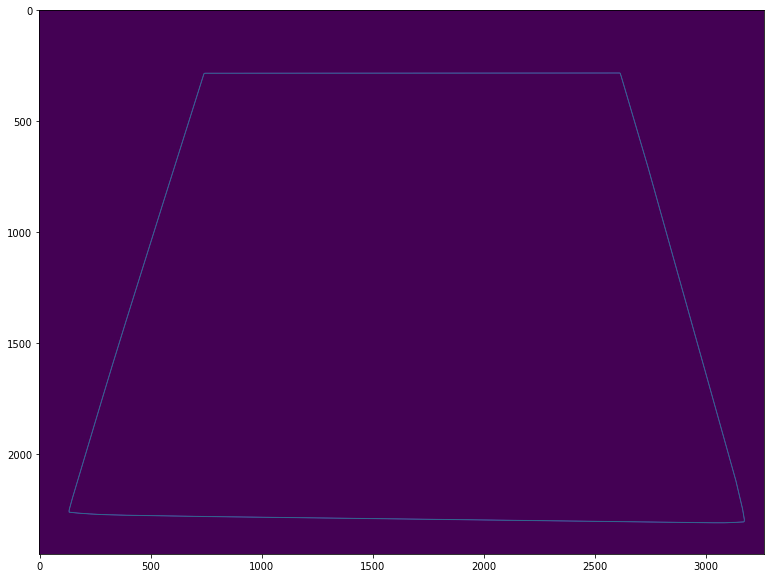

In [9]:
kernel = np.ones((3, 3), np.uint8) # Elemento estructurante para dilatar la imágen.

img2 = cv2.cvtColor(drawing, cv2.COLOR_BGR2GRAY) # Binarización
#img2 = cv2.dilate(img2, kernel, iterations=3)
#img2 = cv2.GaussianBlur(img2, (3,3), 10)
#img2 = cv2.Canny(img2, 200, 400) # Detección de los bordes

plt.figure(figsize = (16,10))
plt.imshow(img2)

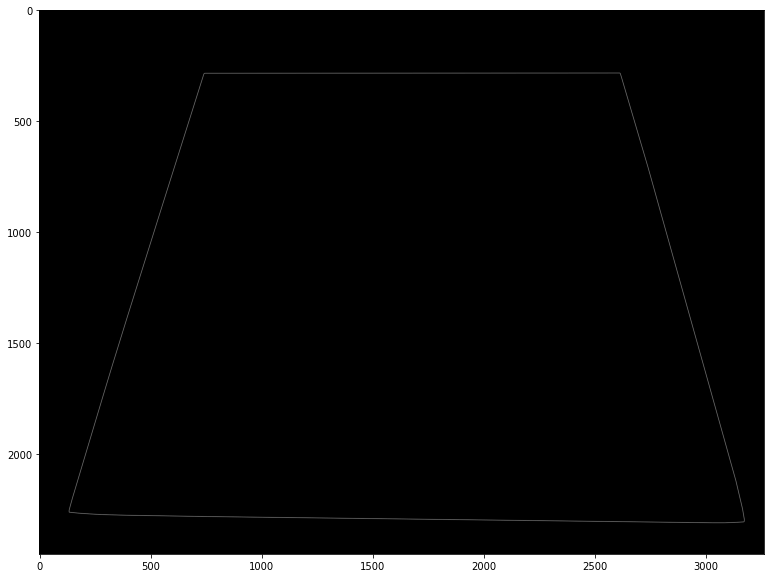

In [10]:
contours, h = cv2.findContours(img2, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE) # Detección de los contornos

img3 = img2.copy()
for c in contours:
    epsilon = 0.1 * cv2.arcLength(c, True) # Calcula el perimetro del contorno
    borders = cv2.approxPolyDP(c, epsilon, True) # Dibuja un polígono rectangular que envuelva el contorno
    cv2.drawContours(img2, [borders], -1, (0, 0, 255), 10)

# Dibuja el polígono representativo del tablero de ajedrez
plt.figure(figsize = (16,10))
plt.imshow(img3, cmap='gray')

In [11]:
# import the necessary packages
from scipy.spatial import distance as dist
import numpy as np
import cv2

def order_points(pts):
    xSorted = pts[np.argsort(pts[:, 0]), :]
    
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    
    return [tl, tr, bl, br]

In [12]:
# Imprime los bordes del polígono
# En caso de que se tengan más de 4 bordes, solo se utilizaran las esquina
# borders
b1 = np.array([list(borders[0][0]), list(borders[1][0]), list(borders[2][0]), list(borders[3][0])])
b1 = order_points(b1)
b1

[array([743, 284], dtype=int32),
 array([2617,  284], dtype=int32),
 array([ 134, 2259], dtype=int32),
 array([3173, 2304], dtype=int32)]

In [13]:
# Determina las coordenadas del rectangulo que representa el ajedrez
(x, y, w, h) = cv2.boundingRect(cntmax) # Obtiene las coordenadas del contorno
b2 = [[x,y],[x+w,y],[x,y+h],[x+w,y+h]]
print (f'x = {x}, y = {y}, w = {w}, h = {h}')
print (f'c1 = ({x},{y}), c2 = ({x+w},{y}), c3 = ({x},{y+h}), c4 = ({x+w},{y+h})')

x = 135, y = 283, w = 3041, h = 2025
c1 = (135,283), c2 = (3176,283), c3 = (135,2308), c4 = (3176,2308)


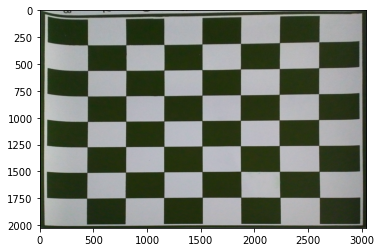

In [14]:
coordinates = np.float32(b1)
final = np.float32([[0,0],[w,0],[0,h],[w,h]])

M = cv2.getPerspectiveTransform(coordinates,final)
dst = cv2.warpPerspective(chessboard,M,(w,h))
plt.imshow(dst)